In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


pd.options.display.max_columns = 20
pd.options.display.max_rows = 10

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error


In [2]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.880,60,11.0014,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.880,60,11.0014,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.880,60,11.0014,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.635,56,8.9981,13,48,61


In [3]:
def non_feature_engineering(raw):
    raw_nfe = raw.copy()
    if 'datetime' in raw_nfe.columns:
        raw_nfe['datetime'] = pd.to_datetime(raw_nfe['datetime'])
        raw_nfe['DateTime'] = pd.to_datetime(raw_nfe['datetime'])
    if raw_nfe.index.dtype == 'int64':
        raw_nfe.set_index('DateTime', inplace=True)
    # bring back
    # if raw_nfe.index.dtype != 'int64':
    #     raw_nfe.reset_index(drop=False, inplace=True)
    raw_nfe = raw_nfe.asfreq('H', method='ffill')
    return raw_nfe

In [4]:
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe

In [5]:
raw_nfe = non_feature_engineering(raw_all)

In [6]:
raw_fe = feature_engineering(raw_all)

In [7]:
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [8]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [9]:
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


In [10]:
fit_reg1 = sm.OLS(Y_train, X_train).fit()
display(fit_reg1.summary())
pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:44:56   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.815
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

In [12]:
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

,MAE,MSE,MAPE
Train,0.008966,0.043793,0.059658
Test,0.009458,0.000147,0.026216


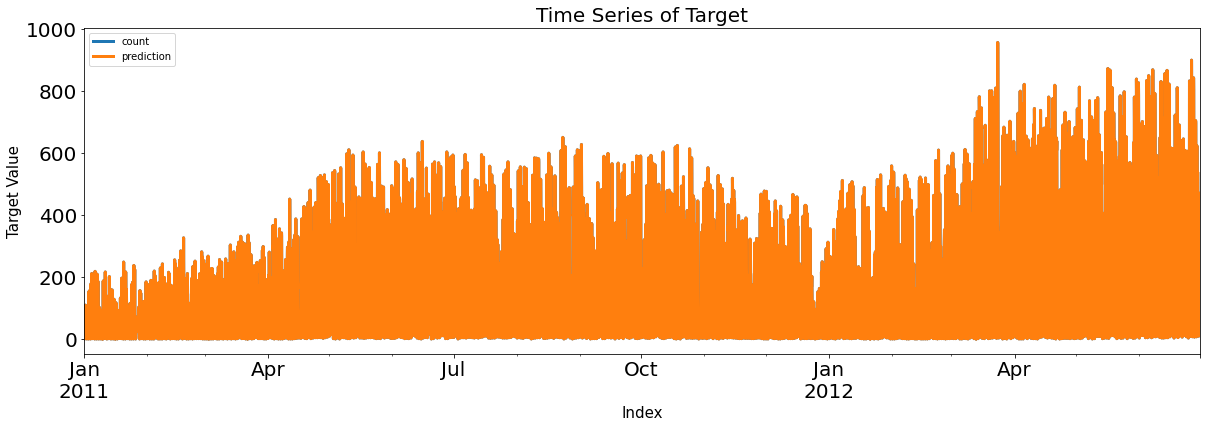

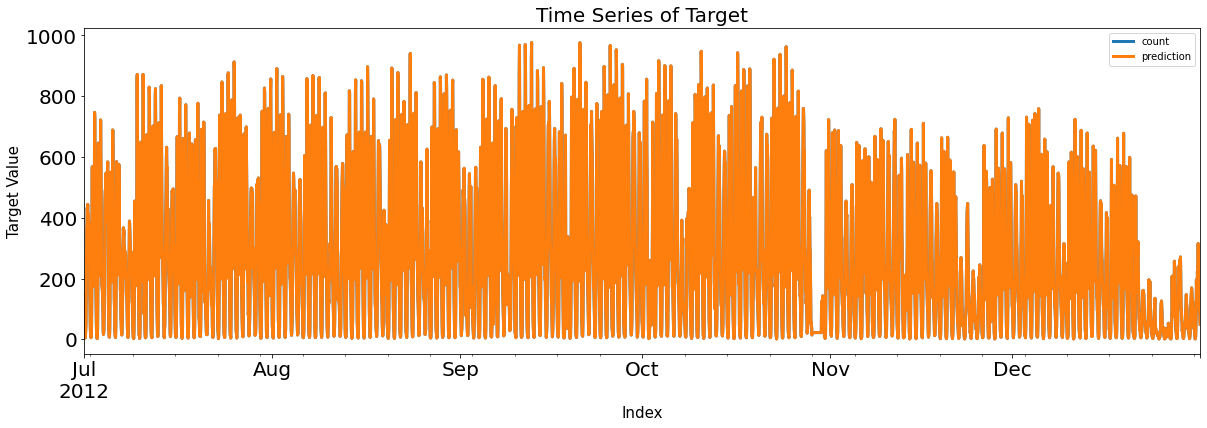

In [13]:
Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)
Score_reg1

In [14]:
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index
Resid_tr_reg1

,Error,RowNum
DateTime,,
2011-01-01 00:00:00,-23.954940,0
2011-01-01 01:00:00,0.044770,1
2011-01-01 02:00:00,0.043921,2
2011-01-01 03:00:00,0.043138,3
2011-01-01 04:00:00,0.042414,4
...,...,...
2012-06-30 19:00:00,-0.003515,13123
2012-06-30 20:00:00,0.000735,13124
2012-06-30 21:00:00,0.000847,13125


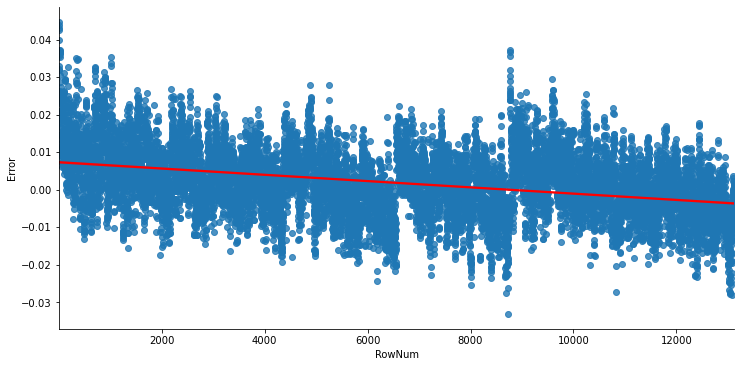

In [15]:
sns.lmplot(data=Resid_tr_reg1.iloc[1:], x='RowNum', y='Error', size=5.2, aspect=2, ci=99, line_kws={'color':'red'})

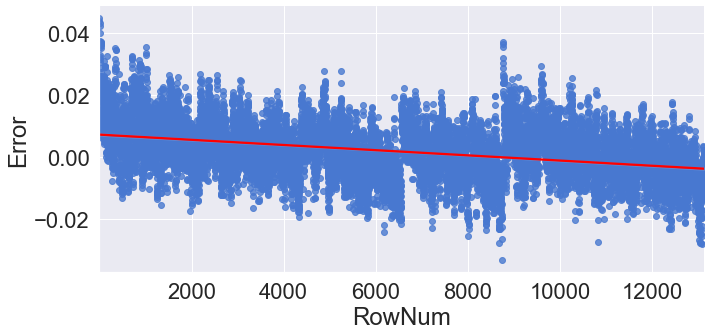

In [16]:
sns.set(palette='muted', color_codes=True, font_scale=2)
sns.lmplot(data=Resid_tr_reg1.iloc[1:], x='RowNum', y='Error', size = 5.2, aspect=2, ci=99, sharey=True,
          fit_reg=True, line_kws={'color':'red'})

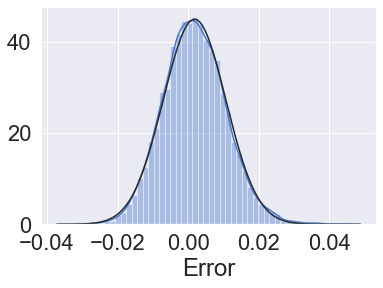

In [17]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], fit=stats.norm)

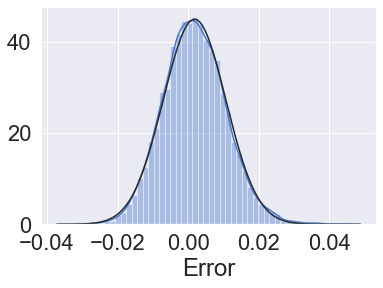

In [18]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], norm_hist='True', fit=stats.norm)

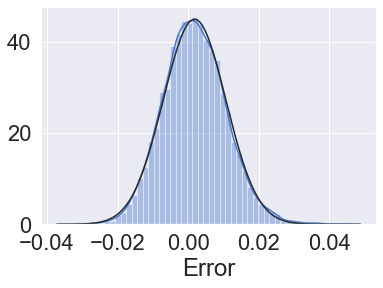

In [19]:
sns.distplot(Resid_tr_reg1['Error'][1:], fit=stats.norm)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

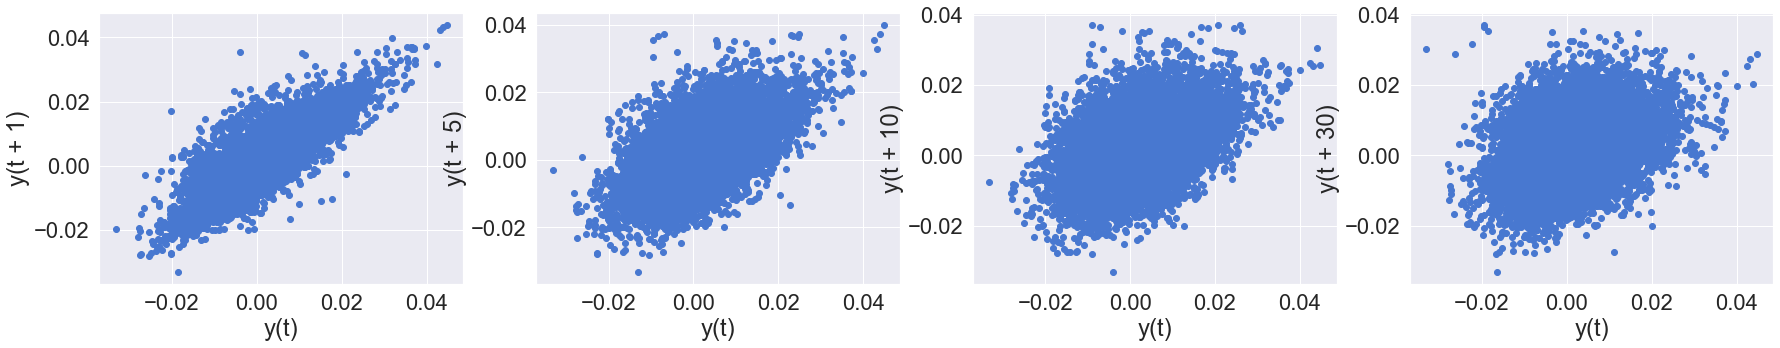

In [20]:
f, ax = plt.subplots(1,4, figsize=(30,5))
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=1, ax=ax[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=5, ax=ax[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=10, ax=ax[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=30, ax=ax[3])
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

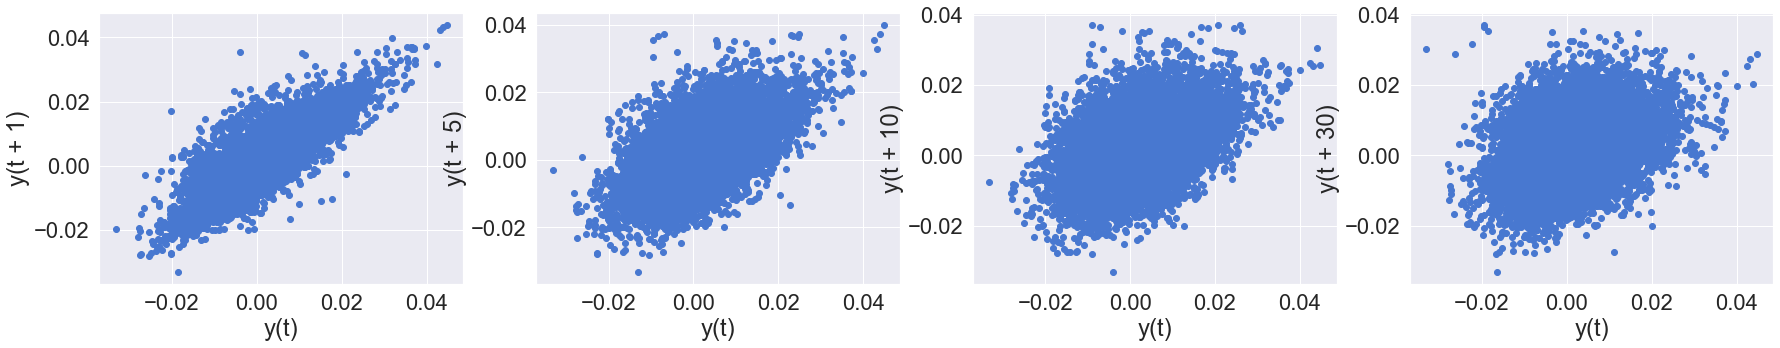

In [21]:
figure, axes = plt.subplots(1,4, figsize=(30,5))
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=30, ax=axes[3])
plt.show()

In [22]:
import statsmodels.api

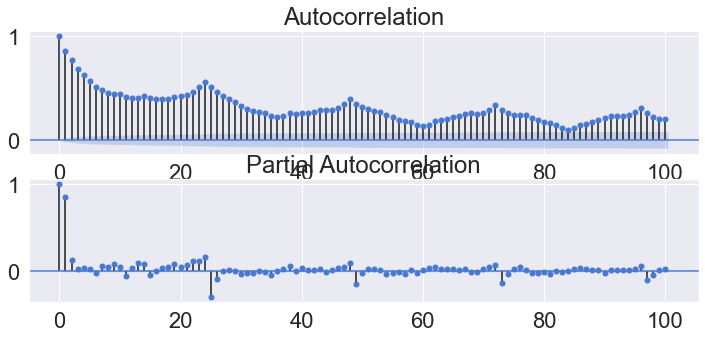

In [23]:
f, ax = plt.subplots(2,1, figsize=(12,5))
f = statsmodels.api.graphics.tsa.plot_acf(Resid_tr_reg1['Error'].iloc[1:], lags=100, ax=ax[0])
f = statsmodels.api.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'].iloc[1:], lags=100, ax=ax[1])

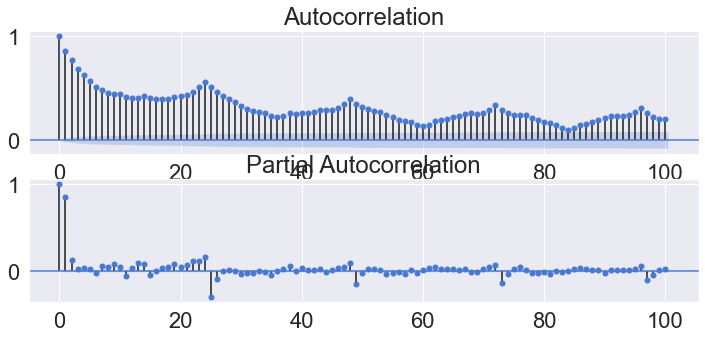

In [24]:
figure, axes = plt.subplots(2,1, figsize=(12,5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[1])

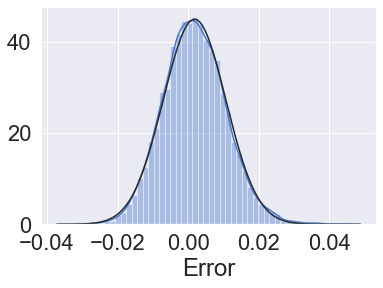

In [25]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], norm_hist=True, fit=stats.norm)

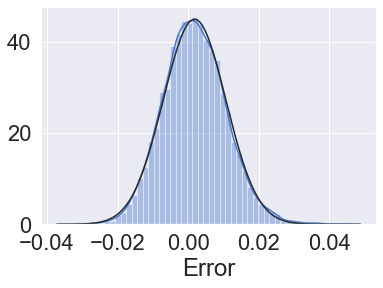

In [26]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], fit=stats.norm)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.976963e+00,0.006131,0.000807,0.010607,0.032142,0.101156,5.92737e-27
p-value,2.164781e-17,0.000000,0.977343,0.999999,1.000000,1.000000,0
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Used Lag,4.100000e+01,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308600e+04,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850e+00,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(5%),-2.861761e+00,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),-2.566888e+00,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,-1.068456e+05,NaN,NaN,NaN,NaN,NaN,NaN


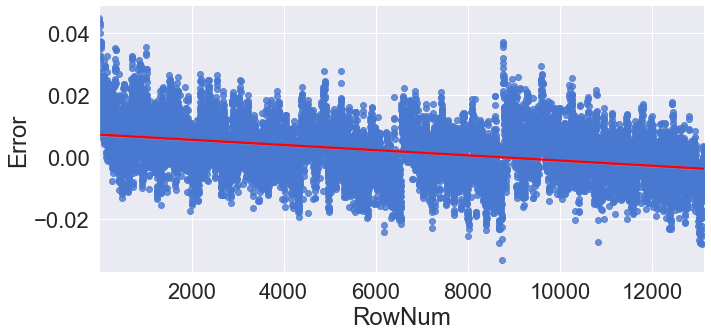

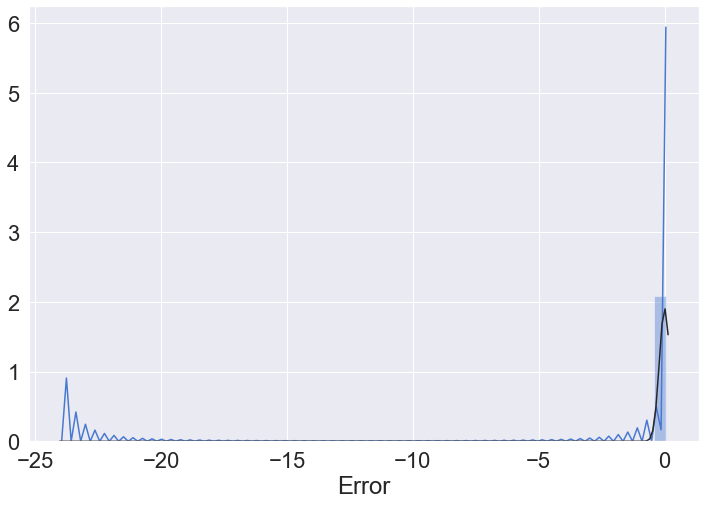

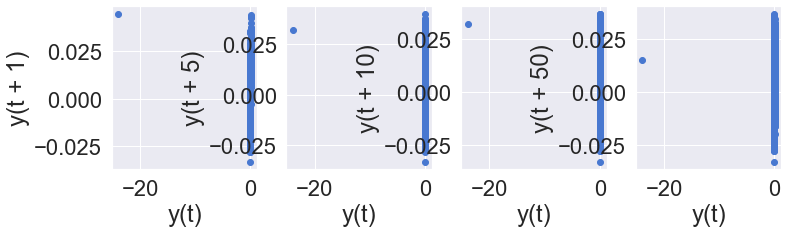

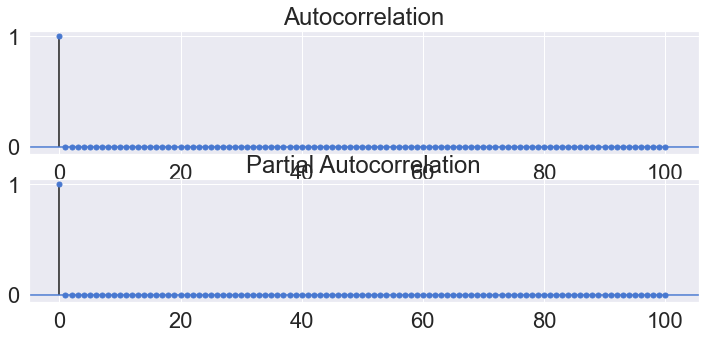

In [27]:
# Error Analysis(Plot)
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index

# Stationarity(Trend) Analysis
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(x='RowNum', y='Error', data=Resid_tr_reg1.iloc[1:],
           fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True, line_kws={'color':'red'})

# Normal Distribution Analysis
figure, axes = plt.subplots(figsize=(12,8))
sns.distplot(Resid_tr_reg1['Error'], norm_hist='True', fit=stats.norm)

# Lag Analysis
length = int(len(Resid_tr_reg1['Error'])/10)
figure, axes = plt.subplots(1, 4, figsize=(12,3))
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'], lag=50, ax=axes[3])

# Autocorrelation Analysis
figure, axes = plt.subplots(2,1,figsize=(12,5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'], lags=100, use_vlines=True, ax=axes[1])

# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[0:4], index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[4].items():
    Stationarity['Critical Value(%s)'%key] = value
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[5]
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1['Error'])], index=['Normality'], columns=['Test Statistics', 'p-value']).T

# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1['Error'], X_train.values, alternative='two-sided')],
                                  index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
Error_Analysis = Error_Analysis.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                                     'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)',
                                     'Maximum Information Criteria'],:]
Error_Analysis

In [28]:
### Functionalize
### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.976963e+00,0.088891,0.006131,0.000807,0.010607,0.032142,0.101156,5.92737e-27
p-value,2.164781e-17,0.100000,0.000000,0.977343,0.999999,1.000000,1.000000,0
Used Lag,4.100000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,-1.068456e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


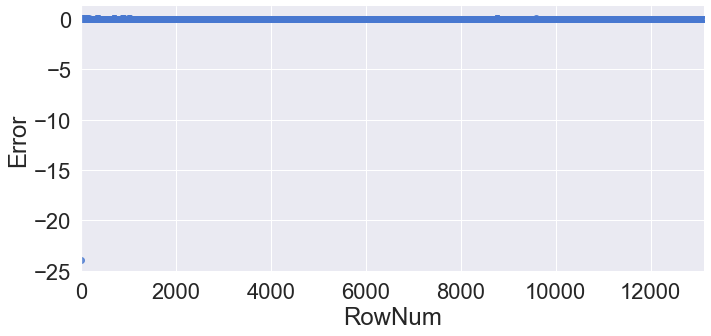

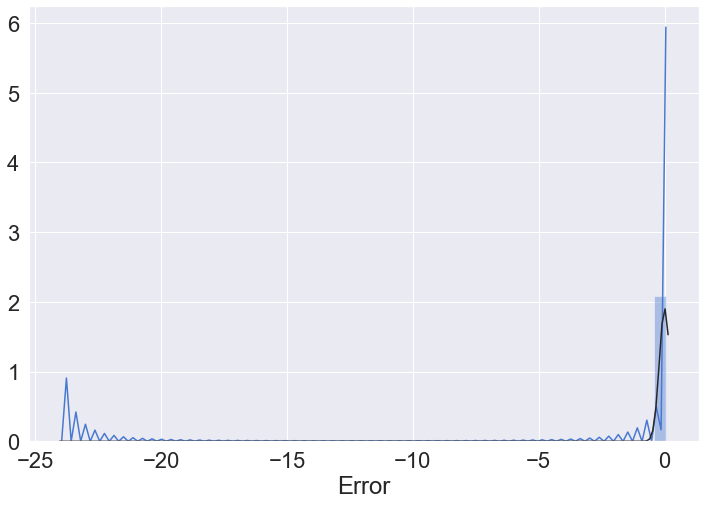

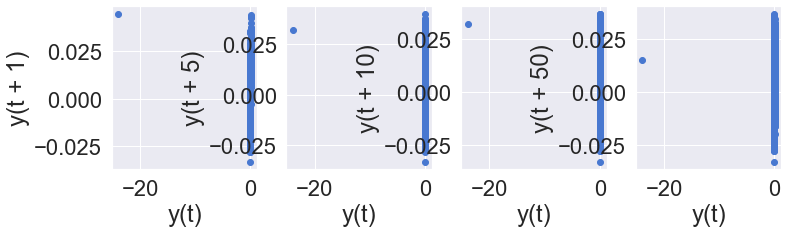

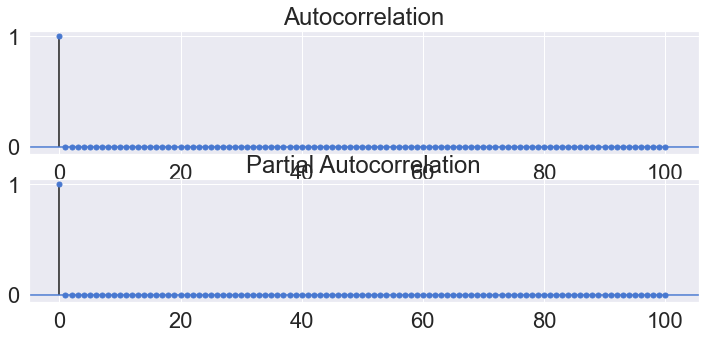

In [29]:
error_analysis(Resid_tr_reg1, ['Error'], X_train, graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.823124e+00,7.520971,9.967269e-01,9615.96476,32903.391013,47262.876994,116653.966004,1.48089
p-value,5.273209e-17,0.010000,1.775184e-16,0.00000,0.000000,0.000000,0.000000,2.04721e-56
Used Lag,4.100000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308500e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,-1.068389e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


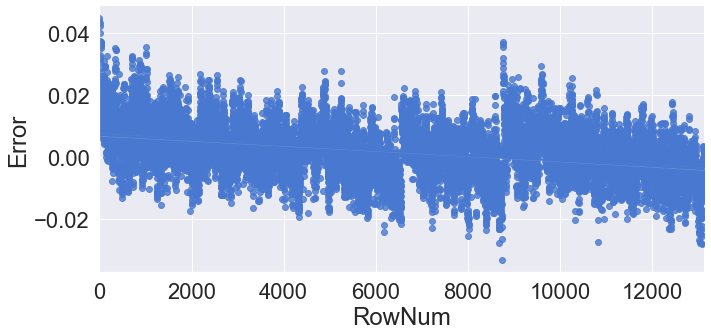

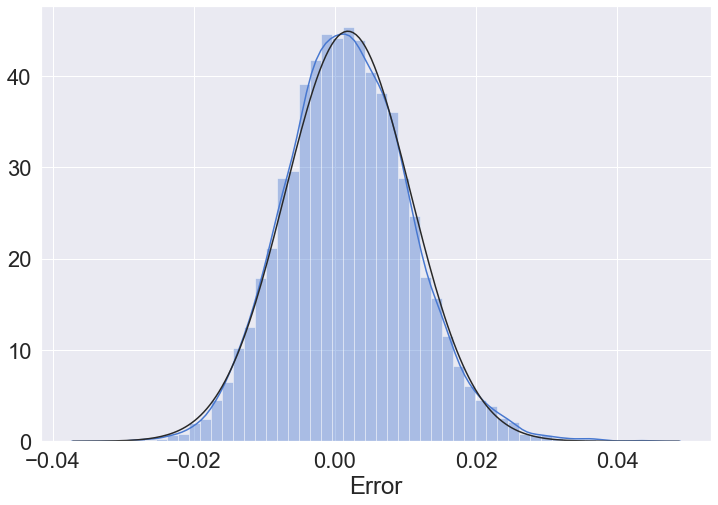

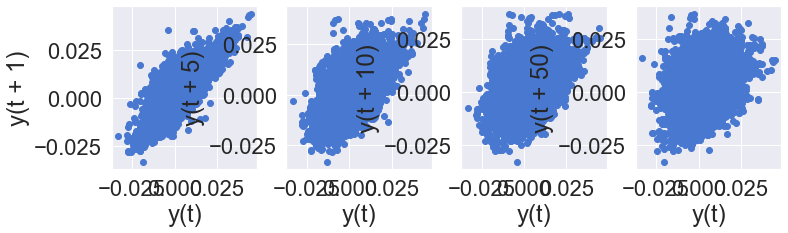

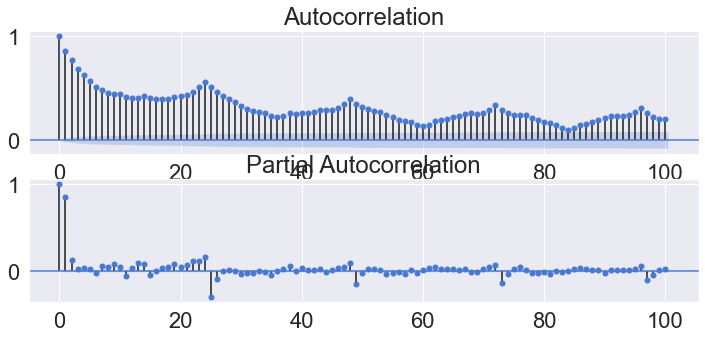

In [30]:
error_analysis(Resid_tr_reg1.iloc[1:], ['Error'], X_train, graph_on=True)

In [35]:
Y_train_rd

,count
DateTime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1
...,...
2012-06-30 19:00:00,374
2012-06-30 20:00:00,292
2012-06-30 21:00:00,213


In [37]:
X_train_rd

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
DateTime,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000
...,...,...,...,...,...,...,...,...,...
2012-06-30 19:00:00,2012-06-30 19:00:00,3,0,0,1,34.44,37.880,44,16.9979
2012-06-30 20:00:00,2012-06-30 20:00:00,3,0,0,1,33.62,38.635,52,11.0014
2012-06-30 21:00:00,2012-06-30 21:00:00,3,0,0,1,33.62,38.635,52,11.0014


Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):                        0.00
Time:                        08:50:39   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.085306,19360.419194,458.483707
Test,150.030952,43410.273703,316.608618


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.253220e+00,11.186108,0.94185,8204.840999,12494.434353,13138.034515,48485.558496,1.76392
p-value,1.473037e-15,0.010000,0.00000,0.000000,0.000000,0.000000,0.000000,2.63524e-115
Used Lag,4.000000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308700e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,1.432528e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


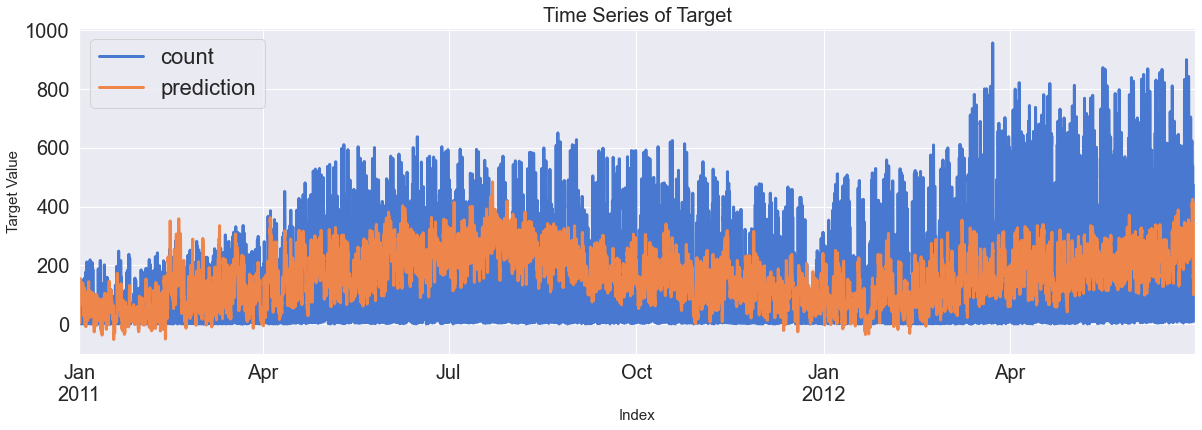

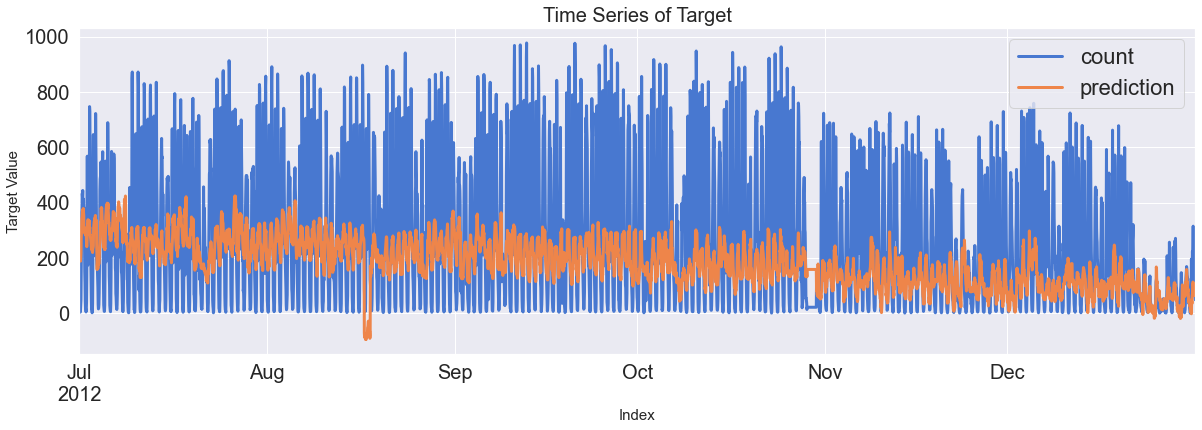

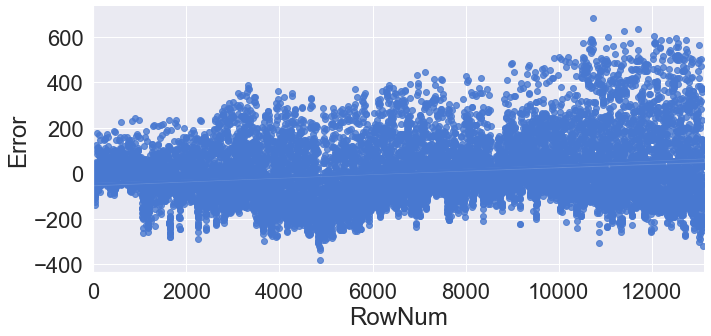

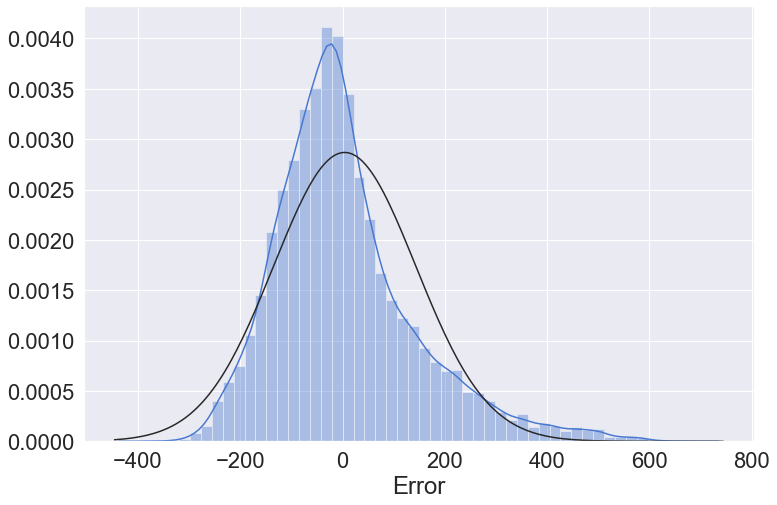

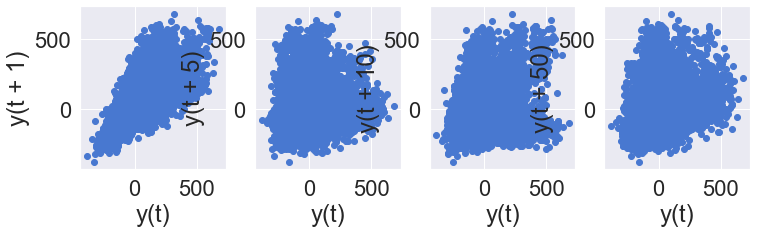

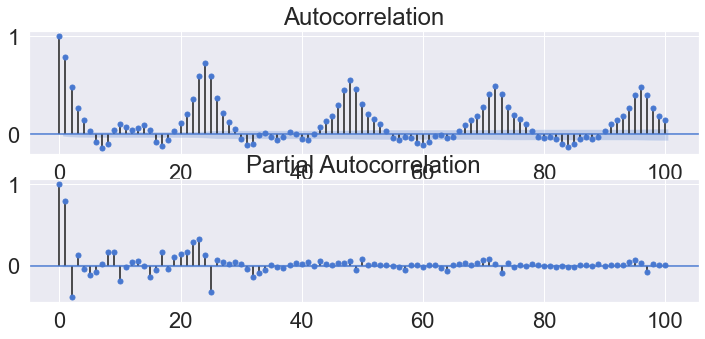

In [39]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

raw_rd = non_feature_engineering(raw_all)

Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname,
                                                                        '2012-07-01')

fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd,
                                                                   Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:00:35   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.815
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.008966,0.043793,0.059658
Test,0.009458,0.000147,0.026216


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.976963e+00,0.088891,0.006131,0.000807,0.010607,0.032142,0.101156,5.92737e-27
p-value,2.164781e-17,0.100000,0.000000,0.977343,0.999999,1.000000,1.000000,0
Used Lag,4.100000e+01,41.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,1.308600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(1%),-3.430850e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,-1.068456e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


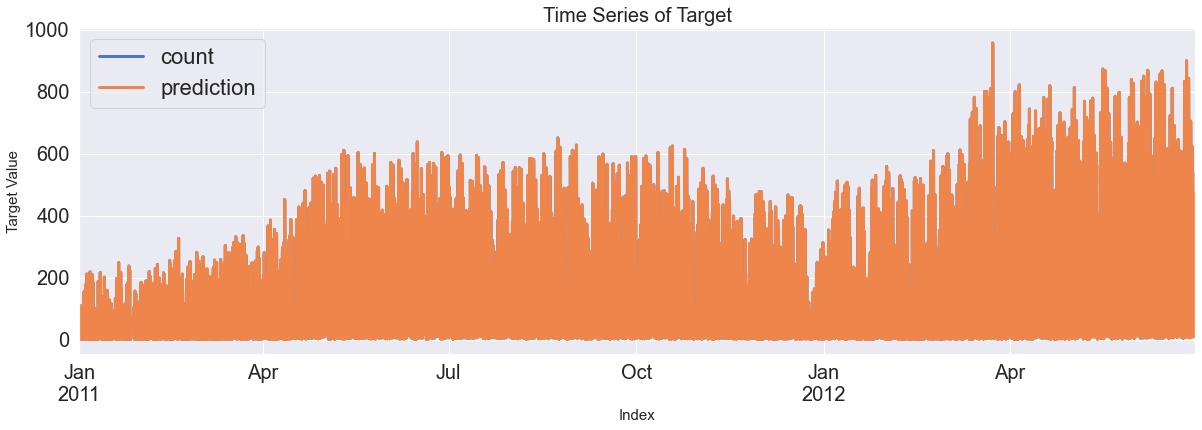

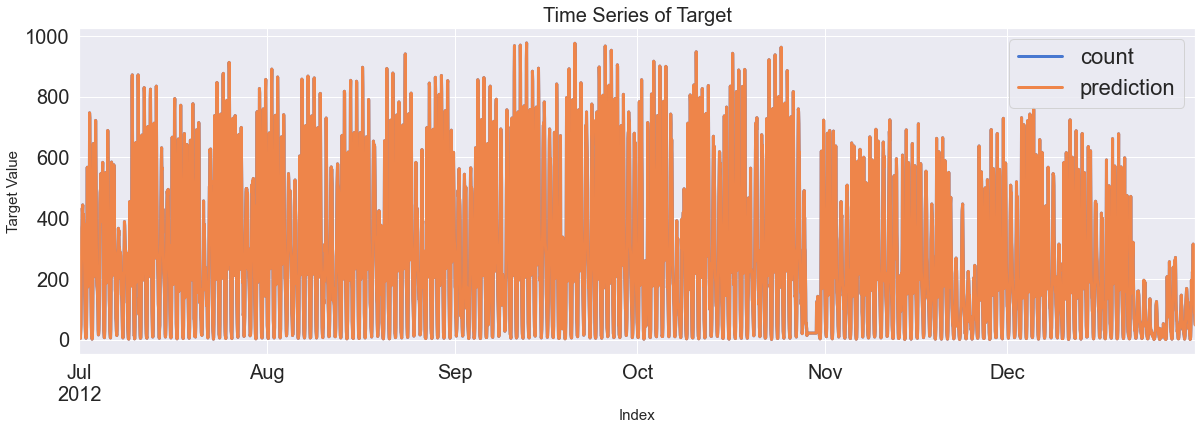

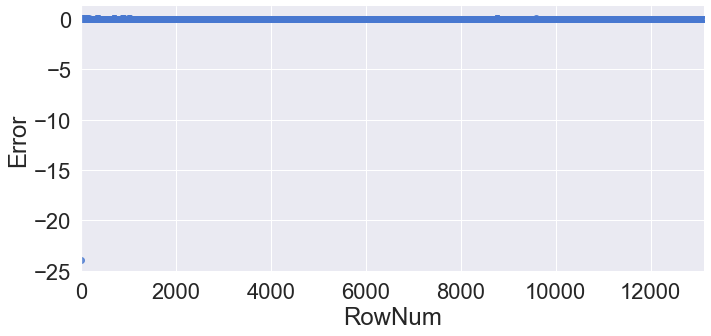

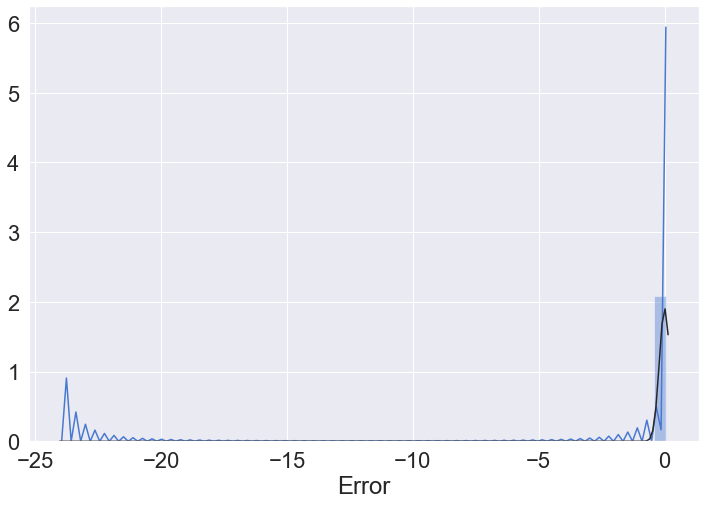

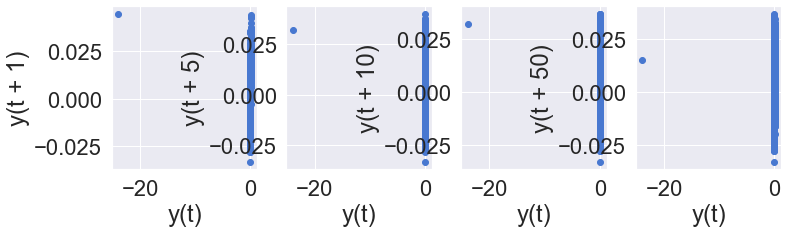

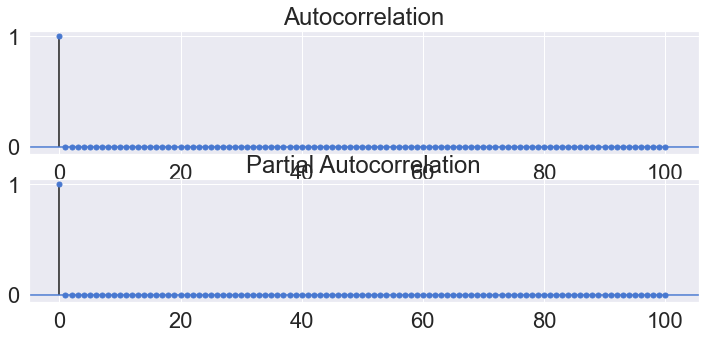

In [41]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

raw_fe = feature_engineering(raw_all)

Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in X_remove+Y_colname]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                   Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)